In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
from undistort import *

In [5]:
def undistort_image(image):
    cal_pickle = pickle.load( open( "camera_cal/calibration_pickle.p", "rb" ) )
    mtx = cal_pickle["mtx"]
    dist = cal_pickle["dist"]
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist
    

Text(0.5,1,'Undistorted Image')

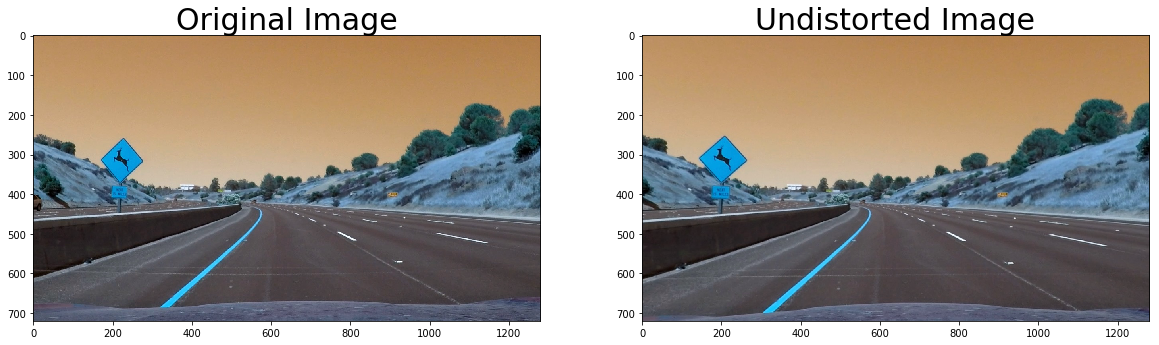

In [6]:
image = cv2.imread('test_images/test2.jpg')
undistortedimage=undistort_image(image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistortedimage)
ax2.set_title('Undistorted Image', fontsize=30)

In [7]:
imshape = image.shape

height = image.shape[0]
offset = 50
offset_height = height - offset
half_frame = image.shape[1] // 2
steps = 6
pixels_per_step = offset_height / steps
window_radius = 200
medianfilt_kernel_size = 51
horizontal_offset = 40

blank_canvas = np.zeros((720, 1280))
colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

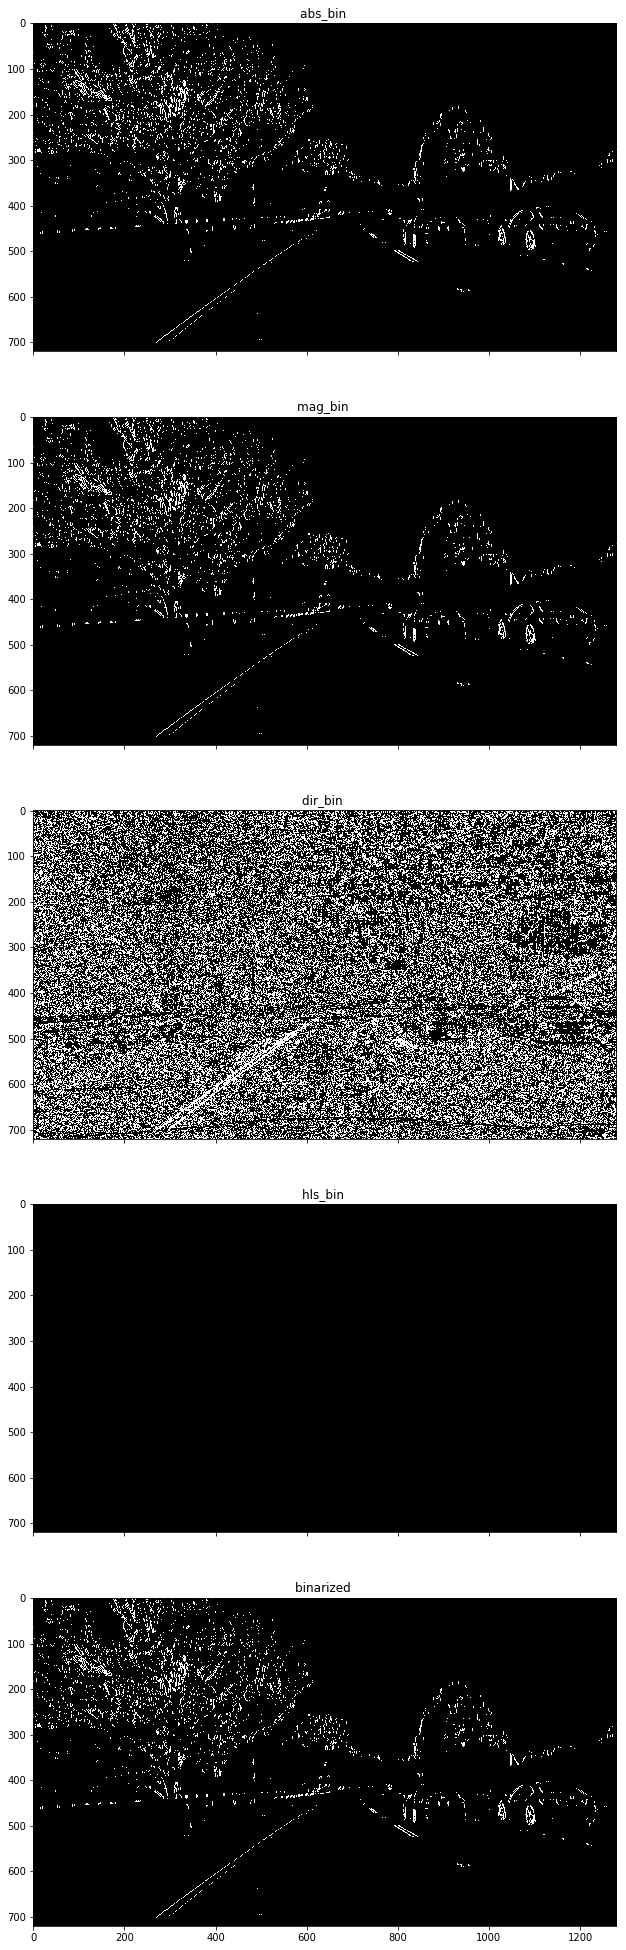

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

# Absolute sobel operation on the image
# inputs -> image,gradient orientation, sobel kernel size,thereshold min and max values

def abs_sobel_threshold(img,orient='x',sobel_kernel = 3,thresh =(0,255)):
#     apply x and y gradient sobel function from opencv
    if orient == 'x':
        sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize = sobel_kernel)
        abs_sobel = np.absolute(sobelx)
    if orient =='y':
        sobely = cv2.Sobel(img,cv2.CV2_64F,0,1,ksize = sobel_kernel)
        abs_sobel = np.absolute(sobely)
    
#     rescale back to 8 bit interger
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
#     creating a copy to apply thresholds
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0])&(scaled_sobel <= thresh[1])] = 1
    return binary_output

# calculate the magnitude of the gradient
# input->image,sobel kernel size,magnitude threshold min and max values

def magnitude_threshold(img,sobel_kernel=3,mag_thresh = (0,255)):
#     sobel tranformation in x 
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize = sobel_kernel)
#     sobel transformation in y
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize = sobel_kernel)
#     calculating the gradient magnitude
#     square root of squares of sobel transfomation in each direction
    gradient_magnitude = np.sqrt(sobelx**2,sobely**2)
#   rescale to 8 bit
    scale_factor = np.max(gradient_magnitude)/255
    gradient_magnitude = (gradient_magnitude/scale_factor).astype(np.uint8)
#     create a binary image of 1 for which met threshold value else zeros
    binary_output = np.zeros_like(gradient_magnitude)
    binary_output[(gradient_magnitude >= mag_thresh[0])&(gradient_magnitude <= mag_thresh[1])] = 1
    return binary_output

# Sobel operation to calculate the direction of the gradient
#input -> image,sobel kernel size, thresh value ranges from (0,np.pi/2)

def direction_threshold(img,sobel_kernel = 3,thresh=(0,np.pi/2)):    
#     sobel tranformation in x 
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize = sobel_kernel)
#     sobel transformation in y
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize = sobel_kernel)
#     calculate the absolute value of gradient direction
    abs_grad_direction = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    binary_output = np.zeros_like(abs_grad_direction)
    binary_output[(abs_grad_direction>=thresh[0])&(abs_grad_direction<=thresh[1])]=1
    return binary_output

# histogram equalization and use it to improve the contrast of our images
# input -> gray image, threshhold value

# def adp_thresh_grayscale(gray,thr=250):
#     img = cv2.equalizeHist(gray)
#     ret,thrs = cv2.threshold(img,thresh=thr,maxval=255,type=cv2.THRESH_BINARY)
#     return thrs

# converting the RGB to HLS and threshold to binary image using the S channel
def hls_threshold(img,thresh=(0,255)):
    img1 = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    hls =cv2.cvtColor(img1,cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel>=thresh[0])&(s_channel<=thresh[1])] = 1
    return binary_output
def binary_threshold(img):
    abs_bin = abs_sobel_threshold(img,orient='x',sobel_kernel = 3,thresh =(50,255))
    mag_bin = magnitude_threshold(img,sobel_kernel=3,mag_thresh = (50,255))
    dir_bin = direction_threshold(img,sobel_kernel = 3,thresh=(0.7,1.3))
    hls_bin = hls_threshold(img,thresh=(170,255))
    
    binarized = np.zeros_like(dir_bin)
    binarized[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | hls_bin == 1] = 1
    
    
    return binarized,abs_bin,mag_bin,dir_bin,hls_bin




if __name__ == "__main__":
    with open('calibration_pickle.p', 'rb') as f:
        save_dict = pickle.load(f)
    mtx = save_dict['mtx']
    dist = save_dict['dist']  
    img_file = 'test_images/test5.jpg'
#     test_display(verbose= False)
    binarized, abs_bin, mag_bin, dir_bin, hls_bin = binary_threshold(img)
    f = plt.figure(figsize=(100,35))
    ax1, ax2, ax3, ax4,ax5 = f.subplots(5, 1, sharex='col', sharey='row')

    ax1.imshow(abs_bin,cmap='gray')
    ax1.set_title('abs_bin ')
    ax2.imshow(mag_bin,cmap='gray')
    ax2.set_title('mag_bin ')
    ax3.imshow(dir_bin,cmap='gray')
    ax3.set_title('dir_bin ')
    ax4.imshow(hls_bin,cmap='gray')
    ax4.set_title('hls_bin ') 
    ax5.imshow(binarized,cmap='gray')
    ax5.set_title('binarized ')
    
    

        
       
    
        
    


    

    
    

    




    

    
    
        
    

Object `cv2.imsaveas` not found.
